# Taller Fourier EDM - Dispositivo vestible

## Práctica 4 - Clasificación de actividades humanas (HAR - Human activity recognition)

### Objetivos:
En esta práctica se busca clasificar las actividades humanas. Partiendo de señales de aceleración y giro. Se extraen características y se ensayan varios clasificadores.

### Actividades

1. Extracción de características  

2. Prueba de distintos clasificadores

3. Evaluación de resultados  

### Base de señales de movimiento

Usaremos la base de datos "Human-Activity-Recognition Using Smartphones Data Set" descrita en [1] y disponible en [2].  
> __NOTA:__ En nuestro Taller, usaremos una versión adaptada de los datos que denominaremos base __HAR__ y está disponible en el directorio __data__. No es necesario bajar la base original.


Este conjunto de datos se recopiló de 30 personas (denominadas "sujetos") que realizaban diferentes actividades con un teléfono inteligente en la cintura. Los datos se registraron mediante sensores (acelerómetro y giroscopio) en dicho teléfono. El experimento se grabó también en video para etiquetar los datos manualmente.
Los datos de acelerómetro y giroscopio fueron adquiridos a una frecuencia de muestreo de 50 Hz.


### Señales de aceleración y giro

Los datos se encuentran en la carpeta __data/UCI_HAR__.
Estos datos difieren levemente de los originales de la base. Han sido adaptados para este notebook.


Cada archivo en formato CSV tiene las siguientes columnas:     
* [acc_x]  aceleración en el eje X
* [acc_y]  aceleración en el eje Y
* [acc_z]  aceleración en el eje Z
* [gyro_x] velocidad angular en torno al eje X
* [gyro_y] velocidad angular en torno al eje Y
* [gyro_z] velocidad angular en torno al eje Z
* [label] etiqueta de actividad
* [subject_id] identificador del sujeto realizando la actividad
* [activity_name] nombre de la actividad

Los datos de aceleración están expresados en unidades de "g". 
Los datos de velocidad angular están expresados en rad/s

### Etiquetas

En el conjunto de datos, las etiquetas se representan con números del 1 al 6 como identificadores.

- CAMINANDO como __1__
- SUBIENDO ESCALERAS como __2__
- BAJANDO ESCALERAS como __3__
- SENTADO como __4__
- DE PIE como __5__
- ACOSTADO como __6__

### Partición de los datos 
- Las lecturas del ___70%___ de los voluntarios se tomaron como ___datos de entrenamiento___ y las del ___30%___ restante se registraron como ___datos de prueba___.

------

[1] Anguita, D., Alessandro Ghio, L. Oneto, Xavier Parra and Jorge Luis Reyes-Ortiz. “A Public Domain Dataset for Human Activity Recognition using Smartphones” The European Symposium on Artificial Neural Networks (2013).  
  
[2] Reyes-Ortiz, Jorge, Davide Anguita, Alessandro Ghio, Luca Oneto, and Xavier Parra. 2013. Human Activity Recognition Using Smartphones. UCI Machine Learning Repository. https://doi.org/10.24432/C54S4K. (Accedido 27/7/2025)

--------

### Notación de consignas

A lo largo del notebook encontrarán las siguientes palabras claves:

* **INVESTIGAR**  -> indica que se requiere investigar un tema y hacer un breve reporte. 


* **COMPLETAR**  -> indica que se requiere completar el código. 
  
  
* **EXPERIMENTAR** -> indica que la celda contiene código funcional que permite experimentar. Es posible, si lo requiere la experimentación duplicar la celda y realizar los cambio que sean de interés en el código.
  
  
* **DISCUTIR** -> se espera una discusión de los experimentos realizados y/o de las preguntas formuladas
  
  
  
* **RESPONDER** -> se espera una respuesta a preguntas concretas

-----
-----

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.fft import fft, fftshift, ifft
from scipy.signal import spectrogram
import matplotlib.pyplot as plt


#estilo de las gráficas
plt.style.use('ggplot')

# autoreload. Los cambios en modulos externos como 'funciones_practica_1.py' se recargan automaticamente
%load_ext autoreload
%autoreload 2

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
#matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo, si se usa jupyter notebook) 
#matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib qt
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
#    Si se usa vscode usar también %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
%matplotlib widget
#---------------------------------------------------




In [2]:
# importar funciones del módulo de aprendizaje sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as ABC

## Parte 1. Carga e inspección de los datos

### 1.1  Cargar los datos de train y test a un DataFrame de Pandas

Los datos de la base HAR que están disponibles en el directorio __data__:  
* __data/har_train.csv__
* __data/har_test.csv__


In [3]:
# COMPLETAR: Cargar los datos de train a un DataFrame de Pandas
df_har_train = pd.read_csv('data/har_train.csv',delimiter=',') 
df_har_test = pd.read_csv('data/har_test.csv',delimiter=',') 


In [4]:
# COMPLETAR Inspeccionar los datos cargados. Ver columnas, tipos de datos, etc.
print(df_har_train)
print(df_har_test)

           acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  label  \
0       1.012817 -0.123217  0.102934  0.030191  0.066014  0.022859      5   
1       1.022833 -0.126876  0.105687  0.043711  0.042699  0.010316      5   
2       1.022028 -0.124004  0.102102  0.035688  0.074850  0.013250      5   
3       1.017877 -0.124928  0.106553  0.040402  0.057320  0.017751      5   
4       1.023680 -0.125767  0.102814  0.047097  0.052343  0.002553      5   
...          ...       ...       ...       ...       ...       ...    ...   
470523  0.632124 -0.158709  0.060450 -0.286205  1.032091  0.083361      2   
470524  0.671960 -0.154120  0.108725 -0.423730  0.871390  0.176435      2   
470525  0.675347 -0.162009  0.128925 -0.425461  0.650441  0.176212      2   
470526  0.660338 -0.202037  0.172251 -0.475547  0.409734  0.163561      2   
470527  0.719353 -0.229127  0.210071 -0.412959  0.199823  0.188734      2   

        subject_id     activity_name  
0                1          STANDING

### 1.2 Separación de gravedad y aceleración corporal

Calcular la aceleración de la gravedad y la aceleración corporal a partir de las señales __acc_x, acc_y, y acc_z__.   Agregar las señales como columnas a los dataframes de train y test.

Los dataframes quedarán ahora con columnas:
__acc_x,	acc_y,	acc_z,	gyro_x,	gyro_y,	gyro_z,	gravity_acc_x,	gravity_acc_y,	gravity_acc_z,	body_acc_x,	body_acc_y,	body_acc_z,	label,	subject_id,	activity_name__



In [5]:
# COMPLETAR 
# Separar gravedad y aceleración corporal
# Aumentar los dataframes con las nuevas columnas
from scipy.signal import butter, sosfilt, sosfreqz
fs = 50.0          
fc = 0.2           
Wn = fc / (fs / 2) #fc normalizada a fs/2

sos = butter(2, Wn, btype='highpass', output='sos')

# Respuesta en frecuencia
w, h = sosfreqz(sos, worN=2000, fs=fs)

def butter_highpass_filter(signal, fs, cutoff=0.2, order=2):
    """
    Aplica un filtro Butterworth pasa-altos a la señal de entrada.

    Parámetros:
        signal (array-like): Señal de entrada a filtrar.
        fs (float): Frecuencia de muestreo en Hz.
        cutoff (float): Frecuencia de corte en Hz (por defecto 0.2 Hz).
        order (int): Orden del filtro Butterworth (por defecto 2).

    Retorna:
        filtered_signal (np.ndarray): La señal filtrada.
    """
    filtered_signal = None
    #COMPLETAR
    sos = butter(order, cutoff, btype='highpass', fs=fs, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

filt_x = butter_highpass_filter(df_har_test["acc_x"].values, fs, cutoff=0.2, order=2)
filt_y = butter_highpass_filter(df_har_test["acc_y"].values, fs, cutoff=0.2, order=2)
filt_z = butter_highpass_filter(df_har_test["acc_z"].values, fs, cutoff=0.2, order=2)
filt_x_tr = butter_highpass_filter(df_har_train["acc_x"].values, fs, cutoff=0.2, order=2)
filt_y_tr = butter_highpass_filter(df_har_train["acc_y"].values, fs, cutoff=0.2, order=2)
filt_z_tr = butter_highpass_filter(df_har_train["acc_z"].values, fs, cutoff=0.2, order=2)
# agregar los valores filtrados al dataframe
df_har_test["body_acc_x"] = filt_x
df_har_test["body_acc_y"] = filt_y
df_har_test["body_acc_z"] = filt_z
df_har_train["body_acc_x"] = filt_x_tr
df_har_train["body_acc_y"] = filt_y_tr
df_har_train["body_acc_z"] = filt_z_tr

In [6]:
# Inspeccionar los dataframes resultantes
display(df_har_train)
display(df_har_test)

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,subject_id,activity_name,body_acc_x,body_acc_y,body_acc_z
0,1.012817,-0.123217,0.102934,0.030191,0.066014,0.022859,5,1,STANDING,0.994977,-0.121046,0.101121
1,1.022833,-0.126876,0.105687,0.043711,0.042699,0.010316,5,1,STANDING,0.969455,-0.120339,0.100232
2,1.022028,-0.124004,0.102102,0.035688,0.074850,0.013250,5,1,STANDING,0.933593,-0.113166,0.093085
3,1.017877,-0.124928,0.106553,0.040402,0.057320,0.017751,5,1,STANDING,0.895117,-0.109902,0.094024
4,1.023680,-0.125767,0.102814,0.047097,0.052343,0.002553,5,1,STANDING,0.867207,-0.106600,0.086826
...,...,...,...,...,...,...,...,...,...,...,...,...
470523,0.632124,-0.158709,0.060450,-0.286205,1.032091,0.083361,2,30,WALKING_UPSTAIRS,-0.360980,0.060227,0.175649
470524,0.671960,-0.154120,0.108725,-0.423730,0.871390,0.176435,2,30,WALKING_UPSTAIRS,-0.309037,0.062708,0.218182
470525,0.675347,-0.162009,0.128925,-0.425461,0.650441,0.176212,2,30,WALKING_UPSTAIRS,-0.294522,0.052805,0.231516
470526,0.660338,-0.202037,0.172251,-0.475547,0.409734,0.163561,2,30,WALKING_UPSTAIRS,-0.298404,0.011643,0.266959


,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,subject_id,activity_name,body_acc_x,body_acc_y,body_acc_z
0,1.041216,-0.269796,0.023780,0.437464,0.531349,0.136528,5,2,STANDING,1.022875,-0.265044,0.023361
1,1.041803,-0.280025,0.076293,0.468264,0.721069,0.097622,5,2,STANDING,0.987100,-0.265673,0.074119
2,1.039086,-0.292663,0.147475,0.498257,0.520328,0.083556,5,2,STANDING,0.948715,-0.268482,0.141399
3,1.054768,-0.292384,0.139906,0.479396,0.372625,0.022861,5,2,STANDING,0.929156,-0.258337,0.128877
4,1.028376,-0.285826,0.119934,0.389894,0.414541,-0.025939,5,2,STANDING,0.868371,-0.242217,0.104528
...,...,...,...,...,...,...,...,...,...,...,...,...
188603,0.989314,-0.190271,-0.038509,-0.424929,0.118239,0.305887,2,24,WALKING_UPSTAIRS,0.059204,0.042764,0.176299
188604,1.068604,-0.217093,0.000626,-0.458488,0.060365,0.252091,2,24,WALKING_UPSTAIRS,0.135656,0.014857,0.208033
188605,1.156389,-0.228348,-0.003512,-0.474912,0.024866,0.233249,2,24,WALKING_UPSTAIRS,0.217700,0.003208,0.196017
188606,1.243857,-0.258322,-0.111786,-0.549326,-0.106027,0.300152,2,24,WALKING_UPSTAIRS,0.296433,-0.026426,0.081999


## Parte 2. Cálculo de características



Para determinar la actividad que está realizando una persona en cada momento, es necesario mirar las señales de acelerómetro en ventanas cortas de tiempo. El largo de ventana a considerar debe ser acorde al problema. Una ventana muy grande puede ser poco precisa temporalmente y abarcar distintas actividades, mientras que una ventana demasiado pequeña puede impedir entender bien las señales para determinar correctamente la actividad. 

En nuestro caso ventanas de 2.5s a 5s podrían ser adecuadas.  

En esta parte de la práctica vamos a agrupar los datos de las series temporales por ventanas de tiempo para posteriormente calcular algunos números en esas ventanas. Estos números, que llamamos __características__ (__features__ en inglés), esperamos que sean distintivos para las actividades y por lo tanto nos permitan discriminar a qué actividad pertenece una ventana de tiempo que estemos analizando.


### 2.1 Cálculo de características por ventanas

A partir del DataFrame __df_har__ queremos obtener un nuevo DataFrame __df_har_features_labels__ donde cada fila tenga las características calculadas y la etiqueta de actividad correspondiente.

Para esto tenemos una función que recibe las señales de los ejes y calcula características y etiquetas por ventanas. Es la misma función de la práctica 2.  
> Nota: Esta función se va a ejecutar sin tener en cuenta la separación en sujetos. Esto no es un problema grave ya que las ventanas serán cortas. Además, como una ventana podría abarcar más de una actividad, se tomará como etiqueta para la ventana, la actividad preponderante en tiempo, en la ventana. 



In [7]:
def calcular_caracteristicas_por_ventanas(signal_x, signal_y, signal_z, labels, fs=50, window_s=4, overlap=0.5):
    """
    Calcula características sobre las señales de acelerómetro en ventanas solapadas.

    Parámetros:
        signal_x, signal_y, signal_z: arrays 1D de aceleración en cada eje
        labels: array 1D de etiquetas (misma longitud que las señales)
        fs: frecuencia de muestreo (Hz)
        window_s: duración de la ventana en segundos
        overlap: fracción de solapamiento entre ventanas (0 a 1)

    Devuelve:
        features_array: array 2D (ventanas x características)
        labels_array: array 1D de etiquetas por ventana (etiqueta preponderante en la ventana)
    """
    n = len(signal_x)
    window_samples = int(window_s * fs)
    step = int(window_samples * (1 - overlap))
    features = []
    labels_window = []

    for start in range(0, n - window_samples + 1, step):
        end = start + window_samples
        x_acc = signal_x[start:end]
        y_acc = signal_y[start:end]
        z_acc = signal_z[start:end]
        label_win = labels[start:end]
        # Características: energía por eje, magnitud media, desviación estándar
        energy_x = np.sum(x_acc**2)
        energy_y = np.sum(y_acc**2)
        energy_z = np.sum(z_acc**2)
        mag = np.sqrt(x_acc**2 + y_acc**2 + z_acc**2)
        mean_mag = np.mean(mag)
        std_mag = np.std(mag)
        
        features.append([
            energy_x, energy_y, energy_z,
            mean_mag, std_mag,
        ])
        # Etiqueta preponderante
        labels_window.append(np.bincount(label_win).argmax())

    features_array = np.array(features)
    labels_array = np.array(labels_window)
    return features_array, labels_array

### 2.2 Calcular las características sobre las señales 
Calcular para __body_acc_x__, __body_acc_y__ y __body_acc_z__ 

In [8]:
# Calcular características en ventanas de 2.56 segundos con 50% de solapamiento para train y test
fs = 50  # frecuencia de muestreo en Hz
ventana_s = 2.56   # ventana en segundos
solapamiento = 0.5 # solapamiento entre ventanas (entre 0 y 1)


X_train, y_train = calcular_caracteristicas_por_ventanas(
    df_har_train.body_acc_x, df_har_train.body_acc_y, df_har_train.body_acc_z,
    df_har_train.label,
    fs=fs, window_s=ventana_s, overlap=solapamiento
)   

X_test, y_test = calcular_caracteristicas_por_ventanas(
    df_har_test.body_acc_x, df_har_test.body_acc_y, df_har_test.body_acc_z,
    df_har_test.label,
    fs=fs, window_s=ventana_s, overlap=solapamiento
)


In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7351, 5) (7351,)
(2946, 5) (2946,)


Cada fila del array **X_train** son 5 características **[energy_x, energy_y, energy_z, mean_mag, std_mag]** que hemos calculado a partir de las señales de aceleración. 

Los elementos del array **y_train** representan la etiqueta "real" de la actividad realizada en la ventana (la realizada por mayor tiempo durante la ventana). 

Otro tanto tendremos en **X_test** e **y_test**.

Con las etiquetas y las características calculadas entrenaremos nuestros clasificadores y también evaluaremos la performance de los mismos.



## Parte 3. Clasificación



En esta parte se entrenará y evaluará un clasificador de __K-vecinos más cercanos__  __(K-Nearest Neighbors o K-NN)__

Ver: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#kneighborsclassifier  



El clasificador se entrenará con los datos de __train__ y evaluará con los datos de __test__.  

El procedimiento usando la biblioteca __sklearn__, es similar para todos los clasificadores disponibles en la biblioteca.

-----  

``` python
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score


# hiperparámetros específicos del clasificador a usar
# En K-NN importa cuántos vecinos se consideran (K) y cómo 
# se miden las distancias en el espacio de características
# 
# Elegimos K y dejamos la métrica por defecto (distancia euclidea) 
K = 5

# crear el clasificador especificando los hiperparámetros
clasificador = KNN(n_neighbors=K) 

# entrenar con el conjunto de datos de train (caracteristicas y etiquetas)
# para entrenar, se llama a la función "fit" del clasificador
clasificador.fit(X_train, y_train)

# una vez entrenado el clasificador, se pueden predecir nuevas entradas, en particular
# todas las del conjunto de test, llamando a la función "predict" del clasificador
y_pred = clasificador.predict(X_test)

# evaluar el desempeño del clasificador es comparar las predicciones contra las etiquetas reales
# predicciones: y_pred
# etiquetas reales: y_test
#
# En este ejemplo calculamos el __accuracy__ o tasa de aciertos. 
accuracy = accuracy_score(y_test, y_pred)

```
-----





### 3.1 Resumir los principales aspectos del clasificador de K vecinos más cercanos

\# RESPONDER

Respuesta:   
.  Clasifica un nuevo dato según las características de los K datos más cercanos (vecinos) en el conjunto de entrenamiento.
.  Se basa en la proximidad (elegimos distancia ecuclidea) entre el dato nuevo y los de entrenamiento.
.  Para valores de K grandes se obtienen clasificaciones más estables, pero es más costoso computacionalmente.


### 3.2 Experimentar variando la cantidad de vecinos clasificador

La cantidad de vecinos del clasificador (cuánto vale K) es lo que se llama un __hiper-parámetro__ del clasificador.

* Experimentar variando la cantidad de vecinos del clasificador
* Realizar una gráfica __accuracy vs. cantidad de vecinos__ 
* Comentar  

In [10]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
# EXPERIMENTAR 
accuracies = []
vecinos = range(1, 100) #valores de K

i=0

for i in vecinos:
    clasificador = KNN(n_neighbors=i) 
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))



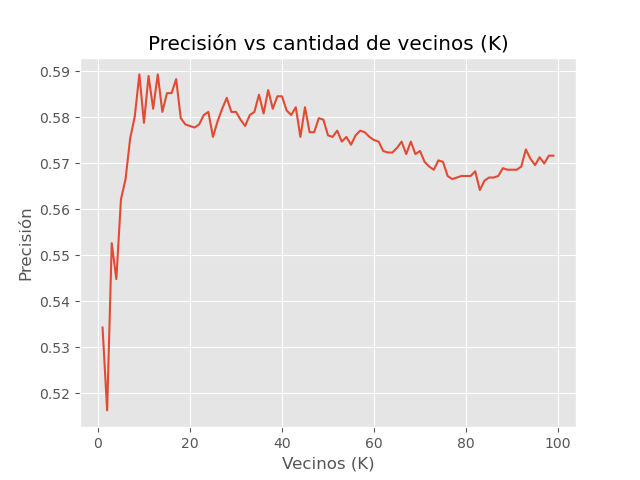

In [11]:
plt.close()
plt.figure()
plt.plot(vecinos,accuracies)
plt.xlabel("Vecinos (K)")
plt.ylabel("Precisión")
plt.title("Precisión vs cantidad de vecinos (K)")
plt.show()


### Comentario

Se observa que la mejor precisión para las características calculadas se obtiene alrededor de los 10 vecinos. Para valores más grandes en lugar de mejorar la precisión esta empeora debido a que se pierden los detalles locales.

### 3.3 Búsqueda de hiper-parámetros por validación cruzada

La búsqueda de los mejores hiperparámetros para un clasificador no es conveniente realizarla evaluando sobre el conjunto de test como hicimos en 3.2.   
El conjunto de test debe reservarse para la evaluación final y no debería usarse para nada que tenga que ver con el entrenamiento. De esta manera, el desempeño sobre el conjunto de test, dará una buena información de cómo va a funcionar el clasificador cuando se enfrente a nuevas muestras nunca vistas antes.

Para no tocar el conjunto de test en la búsqueda de hiperparámetros, se usa habitualmente la estrategia de __validación cruzada__ __(Cross Validation o CV)__ explicada acá:   

https://scikit-learn.org/stable/modules/cross_validation.html

#### 3.3.1 Investigar el procedimiento de validación cruzada

Leer sólo la primera parte de:   
https://scikit-learn.org/stable/modules/cross_validation.html  

Explicar los conceptos

\# INVESTIGAR

.  Si un modelo solo repite las etiquetas que vio durante el entrenamiento, obtendría una precisión perfecta pero fallaría completamente al predecir nuevos datos que nunca vio. Este fenómeno se conoce como overfitting
.  Para evitar el overfitting, se divide el conjunto de datos en datos de entrenamiento y datos de prueba.
.  Además de separar los datos, se utiliza el método de validación cruzada. Este consiste en dividir el conjunto de prueba en n partes (llamadas n-folds), luego se utilizan n-1 folds como los datos de entrenamiento y el restante como validación.


#### 3.3.2 Búsqueda de K mediante validación cruzada y búsqueda en una grilla

Ver https://scikit-learn.org/stable/modules/grid_search.html   

En 3.2 buscamos el mejor K en una grilla de 1 a 100 pero lo hicimos evaluando sobre el conjunto de test que no es lo más apropiado. 

En esta parte realizamos la búsqueda usando validación cruzada sobre el conjunto de entrenamiento. 


\# COMPLETAR

In [12]:
# Búsqueda del mejor K mediante validación cruzada y búsqueda en una grilla 
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': range(1, 100)}    

grid_search = GridSearchCV(
    estimator=KNN(),          # modelo base
    param_grid=params,      # grilla de parámetros
    cv=5,                   # validación cruzada con 4 particiones
    scoring='accuracy',     # métrica de evaluación
)
# Ajustar a los datos de entrenamiento
grid_search.fit(X_train,y_train)
# Mostrar el mejor K encontrado
mejor_k = grid_search.best_params_['n_neighbors']
print(f"El mejor número de vecinos (K) encontrado es: {mejor_k}")
# Reportar el accuracy obtenido en CV para el mejor K
print(f"Accuracy para el mejor K:", grid_search.best_score_)


El mejor número de vecinos (K) encontrado es: 18
Accuracy para el mejor K: 0.5782878970758937


In [13]:
# Desempeño final en test con el mejor K encontrado. 
# Entrenar el clasificador con el mejor K y evaluar en test calculando accuracy

# COMPLETAR
clasificador = KNN(n_neighbors=mejor_k) 
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5797691785471826


### 3.4 Medidas de performance de la clasificación 

#### 3.4.1 Reporte de clasificación

Ver:  https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report  

Para el mejor K encontrado,  realizar el reporte de clasificación sobre test.




\# COMPLETAR

In [14]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.59      0.52       514
           2       0.39      0.38      0.39       493
           3       0.74      0.58      0.65       397
           4       0.57      0.45      0.50       509
           5       0.58      0.69      0.63       514
           6       0.83      0.78      0.80       519

    accuracy                           0.58      2946
   macro avg       0.60      0.58      0.58      2946
weighted avg       0.59      0.58      0.58      2946



\# INVESTIGAR 
* Investigar qué son las metricas que aparecen en el reporte y cómo se calculan
* Explicar cada parte del reporte

....  Precision: Indica la proporción de predicciones positivas correctas, es decir la cantidad de verdaderos positivos (TP)
                  sobre la cantidad total de positivos (TP + FP), entonces precision = TP / (TP+FP).

....  Recall: Indica la proporcion de casos reales positivos detectados sobre el total de casos reales TP + FN, se calcula 
              como recall = TP / ( TP + FN).

....  F1-Score: Es la media armónica entre precision y recall, indica el equilibrio entre precision y recall (mayor si es más cercano a 1, menor si es                   más cercano a 0), se calcula como F1 = 2*(precision*recall) / (precision + recall).

....  Support: Indica la cantidad de muestras de cada clase en el conjunto de prueba asignado al report (y_test).

....  Accuracy: Es el porcentaje total de aciertos, se calcula como accuracy = (TP + TN) / Total

....  Macro avg: Es el promedio entre todos los elementos de una columna.

....  Weighted avg: Es el promedio pnderado por el número de muestras (support) de cada clase, sirve para representar mejor 
                    los casos donde las clases están desbalanceadas


#### 3.4.2 Matriz de confusión

Ver  https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix  

Para el mejor K encontrado,  mostrar las matrices de confusión sobre los datos de entrenamiento y sobre los datos de test. 

Experimentar con valores sin normalizar y normalizados en las matrices.


\# COMPLETAR

Text(0.5, 1.0, 'Matriz de confusión - Prueba (normalizada)')

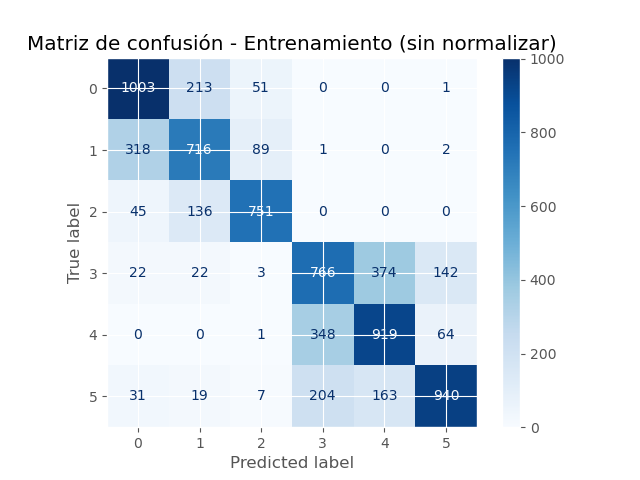

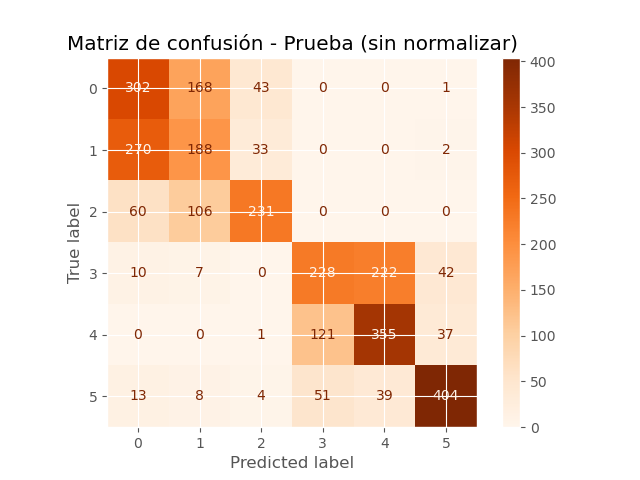

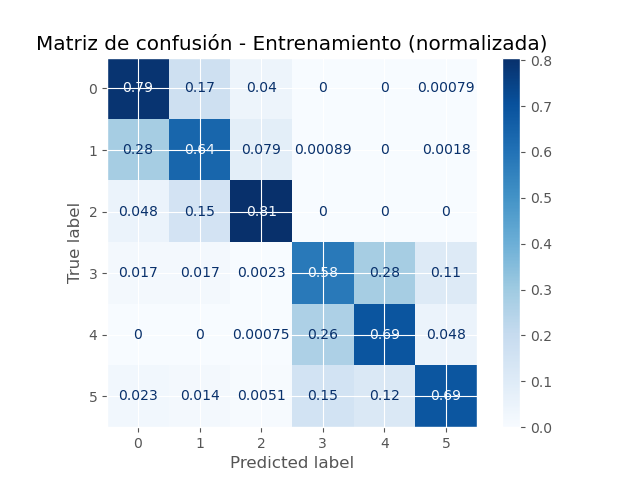

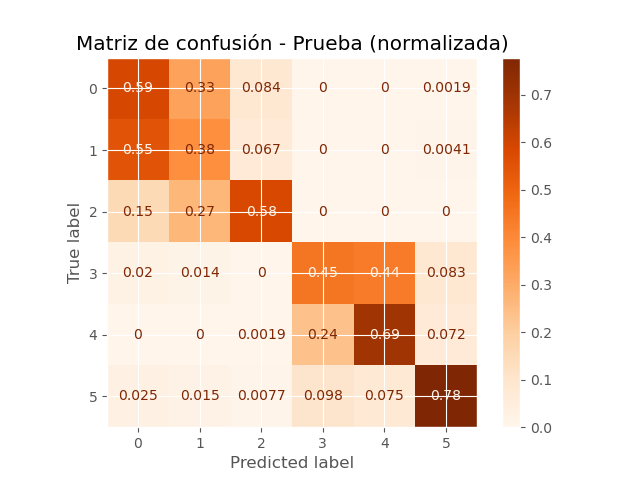

In [15]:
#Mostrar la matriz de confusión en entrenamiento y test
# Usar ConfusionMatrixDisplay de sklearn
from sklearn.metrics import ConfusionMatrixDisplay
clasificador = KNN(n_neighbors=mejor_k) 
clasificador.fit(X_train, y_train)
y_train_pred = clasificador.predict(X_train)
y_test_pred  = clasificador.predict(X_test)


cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (sin normalizar)")

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (sin normalizar)")

cm_train_norm = confusion_matrix(y_train, y_train_pred, normalize='true')
ConfusionMatrixDisplay(cm_train_norm).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (normalizada)")

cm_test_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
ConfusionMatrixDisplay(cm_test_norm).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (normalizada)")


\# INVESTIGAR 
* Explicar cómo se relacionan los valores en el reporte de clasificación de 3.2.1 con los valores en la matriz de confusión de test.
* Mostrar las cuentas para las distintas métricas  del reporte

....  Cada fila de la matriz corresponde a una característica real (del conjunto de datos), mientras que las columnas
corresponden a la predicción del modelo. Los valores en la diagonal son los aciertos del clasificador.
....  El classification report indica la información de cada fila de la matriz.



## Parte 4. Otros clasificadores

Experimentar con algún otro clasificador de sklearn. Cómo todos los clasificadores de sklearn tienen la misma interfaz, el esquema de uso es similar a lo visto en la sección 3 salvo que cada clasificador tiene sus propios hiper-parámetros.

Ver por ejemplo:  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


\# EXPERIMENTAR  
Experimentar con un clasificadore de RandomForest  
* Explicar brevemente el principio de funcionamiento
* Entrenar, evaluar y mostrar resultados
* Comparar con la parte 3 

Explicar el funcionamiento  
.... El clasificador RandomForest utiliza varios árboles de decisión, los cuales son entrenados con diferentes subconjuntos
de los datos de entrenamiento asignados. La predicción del clasificador se obtiene al calcular la predicción de cada árbol 
y tomar la más popular entre todas.



\# COMPLETAR

In [16]:
# EXPERIMENTAR
from sklearn.ensemble import RandomForestClassifier as RF
clasificador_RF = RF(n_estimators=100, max_depth=8)
clasificador_RF.fit(X_train,y_train)

y_pred_train_RF = clasificador_RF.predict(X_train)
y_pred_test_RF = clasificador_RF.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test_RF))


Accuracy: 0.6530889341479973


Text(0.5, 1.0, 'Matriz de confusión - Prueba (normalizada)')

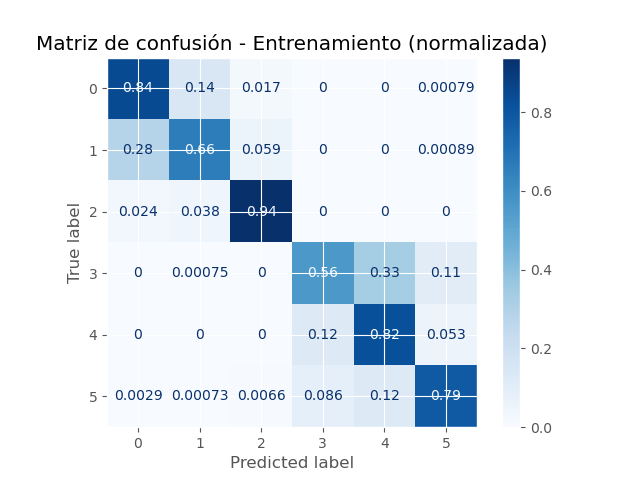

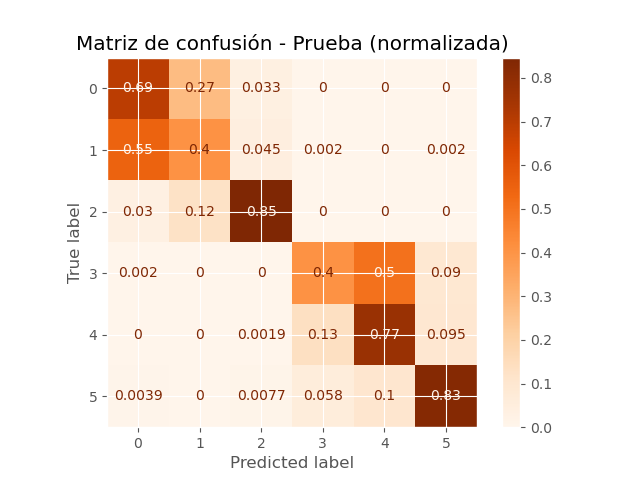

In [17]:
# Matriz de confusión para el conjunto de entrenamiento
cm_train_norm = confusion_matrix(y_train, y_pred_train_RF, normalize='true')
ConfusionMatrixDisplay(cm_train_norm).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (normalizada)")

# Matriz de confusión para el conjunto de test
cm_test_norm = confusion_matrix(y_test, y_pred_test_RF , normalize='true')
ConfusionMatrixDisplay(cm_test_norm).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (normalizada)")


## Parte 5. Prueba con otras características 

Hasta el momento usamos las características de la práctica 2 que ya habíamos visto que no eran muy discriminativas. 
Esto lo pudimos corroborar mirando las matrices de confusión y con los bajos scores obtenidos.

Ahora vamos a calcular nuevas características y ver si logramos mejorar la performance.

### 5.1  Nueva función de cálculo de características por ventanas

Crear una nueva función que reciba el DataFrame de entrenamiento o de test y calcule un conjunto más grande de características.  

> Nota: La nueva función es similar a la definida en la práctica 2 y en 2.1 de este notebook pero ahora recibe el DataFrame y puede calcular características sobre todas las señales disponibles en las columnas del DataFrame (__acc_x,	acc_y,	acc_z,	gyro_x,	gyro_y,	gyro_z,	gravity_acc_x,	gravity_acc_y,	gravity_acc_z,	body_acc_x,	body_acc_y,	body_acc_z,)

\# COMPLETAR  
Función __calcular_caracteristicas_avanzadas_por_ventanas__

In [78]:
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks, welch, butter, filtfilt 


def calcular_caracteristicas_avanzadas_por_ventanas(df, fs=50, window_s=4, overlap=0.5):
    """
    Calcula características avanzadas (tiempo y frecuencia) sobre todas las columnas relevantes del dataframe en ventanas solapadas.

    Parámetros:
        df: DataFrame con columnas de señales (acc, gyro, gravity, body_acc)
        fs: frecuencia de muestreo (Hz)
        window_s: duración de la ventana en segundos
        overlap: fracción de solapamiento entre ventanas (0 a 1)

    Devuelve:
        features_array: array 2D (ventanas x características)
        labels_array: array 1D de etiquetas por ventana (etiqueta preponderante en la ventana)
    """
    #Se trabaja sobre la funcion ya existente
    n = len(df)
    window_samples = int(window_s * fs)
    step = int(window_samples * (1 - overlap))
    features = []
    labels_window = []

    for start in range(0, n - window_samples + 1, step):
        end = start + window_samples
        x_acc = df['body_acc_x'].iloc[start:end].values
        y_acc = df['body_acc_y'].iloc[start:end].values
        z_acc = df['body_acc_z'].iloc[start:end].values
        x_gyro = df['gyro_x'].iloc[start:end].values
        y_gyro = df['gyro_y'].iloc[start:end].values
        z_gyro = df['gyro_z'].iloc[start:end].values
        label_win = df['label'].iloc[start:end].values

       # Características en el dominio del tiempo por eje
        mean_x = np.mean(x_acc)
        mean_y = np.mean(y_acc)
        mean_z = np.mean(z_acc)
        std_x = np.std(x_acc)
        std_y = np.std(y_acc)
        std_z = np.std(z_acc)
        max_x = np.max(x_acc)
        max_y = np.max(y_acc)
        max_z = np.max(z_acc)
        min_x = np.min(x_acc)
        min_y = np.min(y_acc)
        min_z = np.min(z_acc)
        range_x = max_x - min_x
        range_y = max_y - min_y
        range_z = max_z - min_z
        median_x = np.median(x_acc)
        median_y = np.median(y_acc)
        median_z = np.median(z_acc)
        energy_x = np.sum(x_acc**2)
        energy_y = np.sum(y_acc**2)
        energy_z = np.sum(z_acc**2)
        skew_x = skew(x_acc) if std_x > 0 else 0
        skew_y = skew(y_acc) if std_y > 0 else 0
        skew_z = skew(z_acc) if std_z > 0 else 0
        kurt_x = kurtosis(x_acc) if std_x > 0 else 0
        kurt_y = kurtosis(y_acc) if std_y > 0 else 0
        kurt_z = kurtosis(z_acc) if std_z > 0 else 0
        #Gyro
        mean_x_g = np.mean(x_gyro)
        mean_y_g = np.mean(y_gyro)
        mean_z_g = np.mean(z_gyro)
        std_x_g = np.std(x_gyro)
        std_y_g = np.std(y_gyro)
        std_z_g = np.std(z_gyro)
        max_x_g = np.max(x_gyro)
        max_y_g = np.max(y_gyro)
        max_z_g = np.max(z_gyro)
        min_x_g = np.min(x_gyro)
        min_y_g = np.min(y_gyro)
        min_z_g = np.min(z_gyro)
        range_x_g = max_x_g - min_x_g
        range_y_g = max_y_g - min_y_g
        range_z_g = max_z_g - min_z_g
        median_x_g = np.median(x_gyro)
        median_y_g = np.median(y_gyro)
        median_z_g = np.median(z_gyro)
        energy_x_g = np.sum(x_gyro**2)
        energy_y_g = np.sum(y_gyro**2)
        energy_z_g = np.sum(z_gyro**2)
        skew_x_g = skew(x_gyro) if std_x > 0 else 0
        skew_y_g = skew(y_gyro) if std_y > 0 else 0
        skew_z_g = skew(z_gyro) if std_z > 0 else 0
        kurt_x_g = kurtosis(x_gyro) if std_x > 0 else 0
        kurt_y_g = kurtosis(y_gyro) if std_y > 0 else 0
        kurt_z_g = kurtosis(z_gyro) if std_z > 0 else 0


        # Magnitud vectorial en tiempo
        mag = np.sqrt(x_acc**2 + y_acc**2 + z_acc**2)
        mag_gyro = np.sqrt(x_gyro**2 + y_gyro**2 + z_gyro**2)
        mean_mag = np.mean(mag)
        mean_mag_gyro = np.mean(mag_gyro)
        std_mag = np.std(mag)
        std_mag_gyro = np.std(mag_gyro)
        median_mag = np.median(mag)
        median_mag_gyro = np.median(mag_gyro)
        skew_mag = skew(mag) if std_mag > 0 else 0
        kurt_mag = kurtosis(mag) if std_mag > 0 else 0
        skew_mag_gyro = skew(mag_gyro) if std_mag_gyro > 0 else 0
        kurt_mag_gyro = kurtosis(mag_gyro) if std_mag_gyro > 0 else 0

        # Derivada de la magnitud vectorial
        mag_deriv = np.gradient(mag) * fs  # Derivada numérica
        mean_mag_deriv = np.mean(mag_deriv) if len(mag_deriv) > 0 else 0
        std_mag_deriv = np.std(mag_deriv) if len(mag_deriv) > 0 else 0
        #Gyro
        mag_gyro_deriv = np.diff(mag_gyro) * fs
        mean_mag_gyro_deriv = np.mean(mag_gyro_deriv) if len(mag_gyro_deriv) > 0 else 0
        std_mag_gyro_deriv = np.std(mag_gyro_deriv) if len(mag_gyro_deriv) > 0 else 0
        
        # Entropía en tiempo (usando histograma para calcular probabilidad)
        hist_x, _ = np.histogram(x_acc, bins=10, density=True)
        hist_y, _ = np.histogram(y_acc, bins=10, density=True)
        hist_z, _ = np.histogram(z_acc, bins=10, density=True)
        entropy_x = entropy(hist_x + 1e-10)  # Evitar log(0)
        entropy_y = entropy(hist_y + 1e-10)
        entropy_z = entropy(hist_z + 1e-10)
        #Gyro
        hist_x_g, _ = np.histogram(x_gyro, bins=10, density=True)
        hist_y_g, _ = np.histogram(y_gyro, bins=10, density=True)
        hist_z_g, _ = np.histogram(z_gyro, bins=10, density=True)
        entropy_x_g = entropy(hist_x_g + 1e-10)  # Evitar log(0)
        entropy_y_g = entropy(hist_y_g + 1e-10)
        entropy_z_g = entropy(hist_z_g + 1e-10)
        

        # Correlación entre ejes
        corr_xy = np.corrcoef(x_acc, y_acc)[0, 1] if std_x > 0 and std_y > 0 else 0
        corr_xz = np.corrcoef(x_acc, z_acc)[0, 1] if std_x > 0 and std_z > 0 else 0
        corr_yz = np.corrcoef(y_acc, z_acc)[0, 1] if std_y > 0 and std_z > 0 else 0
        corr_xy_g = np.corrcoef(x_gyro, y_gyro)[0, 1] if std_x_g > 0 and std_y_g > 0 else 0
        corr_xz_g = np.corrcoef(x_gyro, z_gyro)[0, 1] if std_x_g > 0 and std_z_g > 0 else 0
        corr_yz_g = np.corrcoef(y_gyro, z_gyro)[0, 1] if std_y_g > 0 and std_z_g > 0 else 0

        # Características en el dominio de la frecuencia
        # FFT para cada eje    
        fft_x = np.fft.fft(x_acc)
        fft_y = np.fft.fft(y_acc)
        fft_z = np.fft.fft(z_acc)
        mag_fft_x = np.abs(fft_x)
        mag_fft_y = np.abs(fft_y)
        mag_fft_z = np.abs(fft_z)
        #Gyro
        fft_x_g = np.fft.fft(x_gyro)
        fft_y_g = np.fft.fft(y_gyro)
        fft_z_g = np.fft.fft(z_gyro)
        mag_fft_x_g = np.abs(fft_x_g)
        mag_fft_y_g = np.abs(fft_y_g)
        mag_fft_z_g = np.abs(fft_z_g)

        # Media, desviación estándar en frecuencia
        mean_fft_x = np.mean(mag_fft_x)
        mean_fft_y = np.mean(mag_fft_y)
        mean_fft_z = np.mean(mag_fft_z)
        std_fft_x = np.std(mag_fft_x)
        std_fft_y = np.std(mag_fft_y)
        std_fft_z = np.std(mag_fft_z)
        #Gyro
        mean_fft_x_g = np.mean(mag_fft_x_g)
        mean_fft_y_g = np.mean(mag_fft_y_g)
        mean_fft_z_g = np.mean(mag_fft_z_g)
        std_fft_x_g = np.std(mag_fft_x_g)
        std_fft_y_g = np.std(mag_fft_y_g)
        std_fft_z_g = np.std(mag_fft_z_g)


        # Energía en frecuencia (suma de cuadrados de amplitudes)
        energy_fft_x = np.sum(mag_fft_x**2)
        energy_fft_y = np.sum(mag_fft_y**2)
        energy_fft_z = np.sum(mag_fft_z**2)
        energy_fft_x_g = np.sum(mag_fft_x_g**2)
        energy_fft_y_g = np.sum(mag_fft_y_g**2)
        energy_fft_z_g = np.sum(mag_fft_z_g**2)

        
        # Entropía en frecuencia
        hist_fft_x, _ = np.histogram(mag_fft_x, bins=10, density=True)
        hist_fft_y, _ = np.histogram(mag_fft_y, bins=10, density=True)
        hist_fft_z, _ = np.histogram(mag_fft_z, bins=10, density=True)
        entropy_fft_x = entropy(hist_fft_x + 1e-10)
        entropy_fft_y = entropy(hist_fft_y + 1e-10)
        entropy_fft_z = entropy(hist_fft_z + 1e-10)
        hist_fft_x_g, _ = np.histogram(mag_fft_x_g, bins=10, density=True)
        hist_fft_y_g, _ = np.histogram(mag_fft_y_g, bins=10, density=True)
        hist_fft_z_g, _ = np.histogram(mag_fft_z_g, bins=10, density=True)
        entropy_fft_x_g = entropy(hist_fft_x_g + 1e-10)
        entropy_fft_y_g = entropy(hist_fft_y_g + 1e-10)
        entropy_fft_z_g = entropy(hist_fft_z_g + 1e-10)

        # Amplitudes de los primeros coeficientes
        num_coeffs = 5
        first_coeffs_x = mag_fft_x[:num_coeffs].tolist()
        first_coeffs_y = mag_fft_y[:num_coeffs].tolist()
        first_coeffs_z = mag_fft_z[:num_coeffs].tolist()

        # Índices de frecuencia dominante (excluyendo DC)
        dom_freq_idx_x = np.argmax(mag_fft_x[1:]) + 1 if len(mag_fft_x) > 1 else 0
        dom_freq_idx_y = np.argmax(mag_fft_y[1:]) + 1 if len(mag_fft_y) > 1 else 0
        dom_freq_idx_z = np.argmax(mag_fft_z[1:]) + 1 if len(mag_fft_z) > 1 else 0

        # Ángulos y orientaciones
        norm_mean = np.sqrt(mean_x**2 + mean_y**2 + mean_z**2)
        angle_x = np.arccos(mean_x / norm_mean) if norm_mean > 0 else 0
        angle_y = np.arccos(mean_y / norm_mean) if norm_mean > 0 else 0
        angle_z = np.arccos(mean_z / norm_mean) if norm_mean > 0 else 0
        #Gyro
        norm_mean_g = np.sqrt(mean_x_g**2 + mean_y_g**2 + mean_z_g**2)
        angle_x_g = np.arccos(mean_x_g / norm_mean_g) if norm_mean_g > 0 else 0
        angle_y_g = np.arccos(mean_y_g / norm_mean_g) if norm_mean_g > 0 else 0
        angle_z_g = np.arccos(mean_z_g / norm_mean_g) if norm_mean_g > 0 else 0

        # Pitch y Roll
        pitch = np.arctan2(x_acc, np.sqrt(y_acc**2 + z_acc**2))
        roll = np.arctan2(y_acc, z_acc)
        pitch_mean = np.mean(pitch)
        pitch_std = np.std(pitch)
        roll_mean = np.mean(roll)
        roll_std = np.std(roll)
        #Gyro
        pitch_g = np.arctan2(x_gyro, np.sqrt(y_gyro**2 + z_gyro**2))
        roll_g = np.arctan2(y_gyro, z_gyro)
        pitch_mean_g = np.mean(pitch_g)
        pitch_std_g = np.std(pitch_g)
        roll_mean_g = np.mean(roll_g)
        roll_std_g = np.std(roll_g)

        # IQR (Rango intercuartil)
        iqr_x = np.percentile(x_acc, 75) - np.percentile(x_acc, 25)
        iqr_y = np.percentile(y_acc, 75) - np.percentile(y_acc, 25)
        iqr_z = np.percentile(z_acc, 75) - np.percentile(z_acc, 25)
        iqr_mag = np.percentile(mag, 75) - np.percentile(mag, 25)

        # Coeficientes de autoregresión (orden 4)
        lags = 4
        ar_coeff_x = [0] * lags
        ar_coeff_y = [0] * lags
        ar_coeff_z = [0] * lags
        try:
            model_x = AutoReg(x_acc, lags=lags).fit()
            ar_coeff_x = model_x.params[1:lags+1]
        except:
            pass  # Se pone 0 si no hay fit
        try:
            model_y = AutoReg(y_acc, lags=lags).fit()
            ar_coeff_y = model_y.params[1:lags+1]
        except:
            pass
        try:
            model_z = AutoReg(z_acc, lags=lags).fit()
            ar_coeff_z = model_z.params[1:lags+1]
        except:
            pass

        # Zero Crossing Rate
        zcr_x = np.sum(np.diff(np.sign(x_acc)) != 0) / len(x_acc)
        zcr_y = np.sum(np.diff(np.sign(y_acc)) != 0) / len(y_acc)
        zcr_z = np.sum(np.diff(np.sign(z_acc)) != 0) / len(z_acc)
            
        # Número de picos
        peaks, _ = find_peaks(mag)
        num_peaks = len(peaks)

        def energy_bands(signal, fs=50):
            """
            Divide la energía en bandas tipo wavelet sin usar pywt.
            """
            # Filtros aproximados de niveles wavelet
            bands = [
                (0.0, 2.0),   # nivel 1 -> muy baja frecuencia (A4)
                (2.0, 4.0),   # nivel 2
                (4.0, 8.0),   # nivel 3
                (8.0, 16.0),  # nivel 4
                (16.0, 24.9)  # nivel 5 (frecuencias altas)
            ]
            energies = []
            for low, high in bands:
                if low == 0.0:
                    b, a = butter(4, high / (fs/2), btype='low')
                else:
                    b, a = butter(4, [low / (fs/2), high / (fs/2)], btype='band')
                filtered = filtfilt(b, a, signal)
                energies.append(np.sum(filtered**2))
            total_energy = np.sum(energies) + 1e-10
            rel_energies = [e / total_energy for e in energies]
            return rel_energies

        # Energías por eje (acelerómetro)
        w_x = energy_bands(x_acc, fs)
        w_y = energy_bands(y_acc, fs)
        w_z = energy_bands(z_acc, fs)
        w_mag = energy_bands(mag, fs)
        
        # Energías por eje (giroscopio)
        w_xg = energy_bands(x_gyro, fs)
        w_yg = energy_bands(y_gyro, fs)
        w_zg = energy_bands(z_gyro, fs)
        w_magg = energy_bands(mag_gyro, fs)

        features.append([
            mean_x, mean_y, mean_z,
            std_x, std_y, std_z,
            max_x, max_y, max_z,
            min_x, min_y, min_z,
            range_x, range_y, range_z,
            median_x, median_y, median_z,
            energy_x, energy_y, energy_z,
            skew_x, skew_y, skew_z,
            kurt_x, kurt_y, kurt_z,
            std_x_g, std_y_g, std_z_g,
            max_x_g, max_y_g, max_z_g,
            min_x_g, min_y_g, min_z_g,
            range_x_g, range_y_g, range_z_g,
            median_x_g, median_y_g, median_z_g,
            energy_x_g, energy_y_g, energy_z_g,
            skew_x_g, skew_y_g, skew_z_g,
            kurt_x_g, kurt_y_g, kurt_z_g,
            entropy_x, entropy_y, entropy_z,
            entropy_x_g, entropy_y_g, entropy_z_g,
            corr_xy, corr_xz, corr_yz,
            corr_xy_g, corr_xz_g, corr_yz_g,
            mean_mag, std_mag, median_mag,
            mean_mag_gyro, std_mag_gyro, median_mag_gyro,
            skew_mag, kurt_mag,
            skew_mag_gyro, kurt_mag_gyro,
            mean_mag_deriv, std_mag_deriv,
            mean_mag_gyro_deriv, std_mag_gyro_deriv,
            mean_fft_x, mean_fft_y, mean_fft_z,
            std_fft_x, std_fft_y, std_fft_z,
            energy_fft_x, energy_fft_y, energy_fft_z,
            std_fft_x_g, std_fft_y_g, std_fft_z_g,
            energy_fft_x_g, energy_fft_y_g, energy_fft_z_g,
            entropy_fft_x, entropy_fft_y, entropy_fft_z,
            entropy_fft_x_g, entropy_fft_y_g, entropy_fft_z_g,
            *first_coeffs_x, *first_coeffs_y, *first_coeffs_z,
            dom_freq_idx_x, dom_freq_idx_y, dom_freq_idx_z,
            angle_x, angle_y, angle_z,
            angle_x_g, angle_y_g, angle_z_g,
            pitch_mean, pitch_std, roll_mean, roll_std,
            pitch_mean_g, pitch_std_g, roll_mean_g, roll_std_g,
            iqr_x, iqr_y, iqr_z, iqr_mag,
            *ar_coeff_x, *ar_coeff_y, *ar_coeff_z,
            zcr_x, zcr_y, zcr_z,
            num_peaks,
            *w_x, *w_y, *w_z, *w_mag,
            *w_xg, *w_yg, *w_zg, *w_magg
            
        ])
        # Etiqueta preponderante
        labels_window.append(np.bincount(label_win).argmax())

    features_array = np.array(features)
    labels_array = np.array(labels_window)
    return features_array, labels_array

### 5.2 Clasificación con las nuevas características 

* Entrenar  y evaluar los clasificadores  con las nuevas características
* Comparar con los resultados de las partes 3 y 4.

\# COMPLETAR

In [79]:
# Calcular características en ventanas de 4 segundos con 50% de solapamiento
fs = 50  # frecuencia de muestreo en Hz
ventana_s = 2.56
solapamiento = 0.5


X_train, y_train = calcular_caracteristicas_avanzadas_por_ventanas(
    df_har_train,
    fs=fs, window_s=ventana_s, overlap=solapamiento
)   

X_test, y_test = calcular_caracteristicas_avanzadas_por_ventanas(
    df_har_test,
    fs=fs, window_s=ventana_s, overlap=solapamiento
)
 


In [60]:
# print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2946, 150) (2946,)


In [24]:
# EXPERIMENTAR
clasificador = RF(n_estimators=200,       
    max_depth=8,            
    min_samples_split=5,     
    min_samples_leaf=3,     
    max_features='log2',    
    random_state=66
)
clasificador.fit(X_train,y_train)

y_pred_train_RF = clasificador.predict(X_train)
y_pred_test_RF = clasificador.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test_RF))


Accuracy: 0.8778004073319755


Text(0.5, 1.0, 'Matriz de confusión - Prueba (normalizada)')

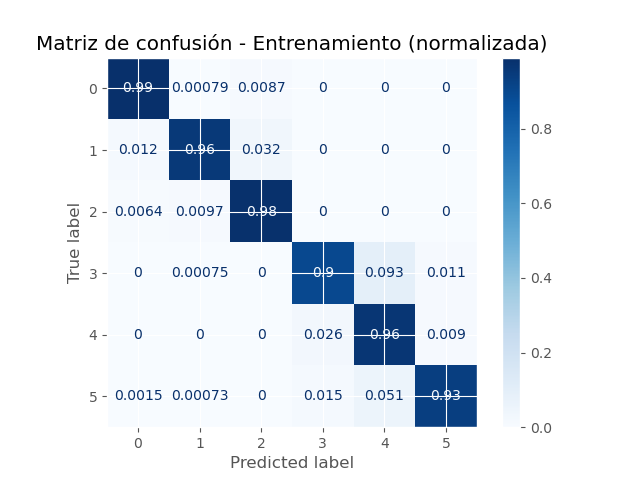

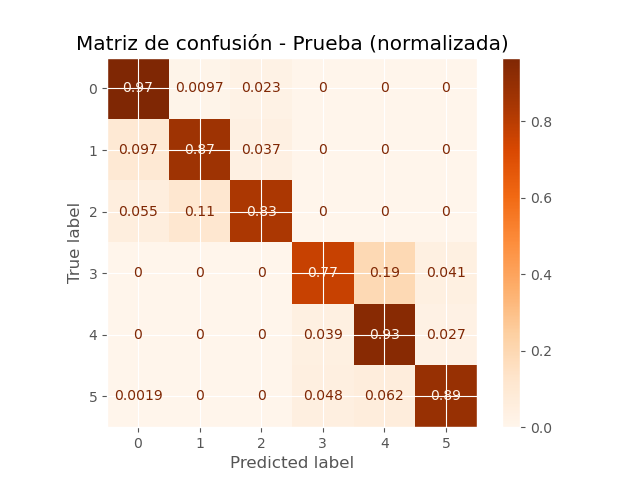

In [25]:
# Matriz de confusión para el conjunto de entrenamiento
cm_train_norm = confusion_matrix(y_train, y_pred_train_RF, normalize='true')
ConfusionMatrixDisplay(cm_train_norm).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (normalizada)")

# Matriz de confusión para el conjunto de test
cm_test_norm = confusion_matrix(y_test, y_pred_test_RF , normalize='true')
ConfusionMatrixDisplay(cm_test_norm).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (normalizada)")


### 5.3 Importancia de las características

En la nueva función de cálculo de características calculamos un número grande de características.  
Pero, ¿cuáles de ellas son más importantes para la clasificación?

En la práctica 2 hicimos una inspección visual de las características pero hay algunos otros mecanismos más apropiados para determinar la importancia y/o para seleccionar las características más apropiadas.


#### 5.3.1 "Feature importance" en el clasificador de RandomForest

El clasificador de RandomForest tiene una función __feature_importance__ que devuelve esa información

\# INVESTIGAR
* Ver de qué manera se determina la importancia de las características en este clasificador
* Ver cuáles resultaron las características más importantes en el clasificador que entrenaron


Top 10 características más importantes:
angle_y_g: 0.0249
std_fft_x: 0.0243
max_x: 0.0239
roll_mean_g: 0.0221
mean_mag_deriv: 0.0210
mean_fft_x: 0.0203
mean_x_g: 0.0201
entropy_fft_z_g: 0.0199
entropy_fft_x_g: 0.0189
min_x_g: 0.0180


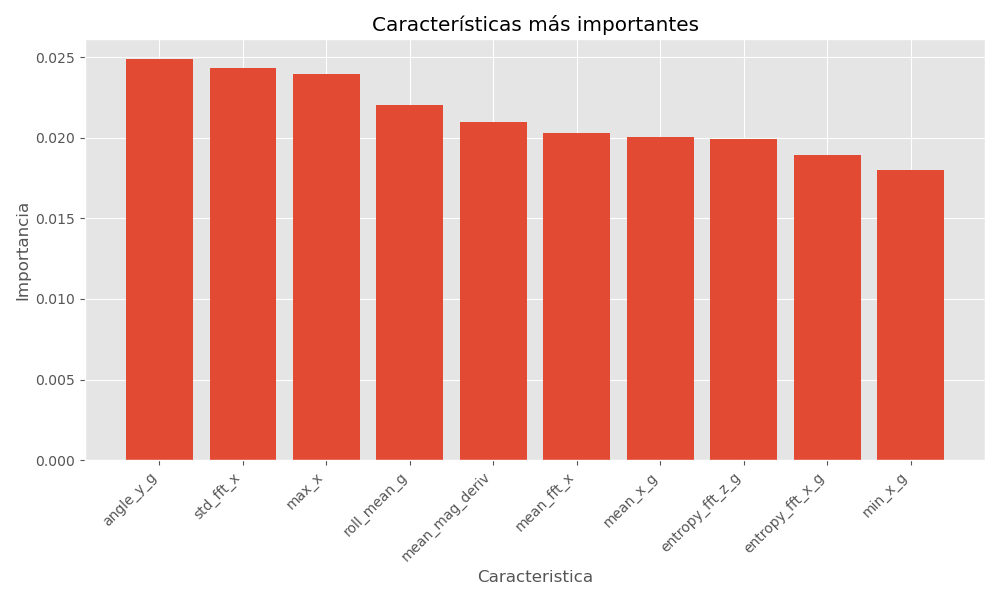

In [71]:
# Mostrar la importancia de las características del clasificador Random Forest
nombres_caracteristicas = [
    'mean_x', 'mean_y', 'mean_z',
    'std_x', 'std_y', 'std_z',
    'max_x', 'max_y', 'max_z',
    'min_x', 'min_y', 'min_z',
    'range_x', 'range_y', 'range_z',
    'median_x', 'median_y', 'median_z',
    'energy_x', 'energy_y', 'energy_z',
    'skew_x', 'skew_y', 'skew_z',
    'kurt_x', 'kurt_y', 'kurt_z',
    'mean_x_g', 'mean_y_g', 'mean_z_g',
    'std_x_g', 'std_y_g', 'std_z_g',
    'max_x_g', 'max_y_g', 'max_z_g',
    'min_x_g', 'min_y_g', 'min_z_g',
    'range_x_g', 'range_y_g', 'range_z_g',
    'median_x_g', 'median_y_g', 'median_z_g',
    'energy_x_g', 'energy_y_g', 'energy_z_g',
    'skew_x_g', 'skew_y_g', 'skew_z_g',
    'kurt_x_g', 'kurt_y_g', 'kurt_z_g',
    'entropy_x', 'entropy_y', 'entropy_z',
    'entropy_fft_x_g', 'entropy_fft_y_g', 'entropy_fft_z_g',
    'corr_xy', 'corr_xz', 'corr_yz',
    'corr_xy_g', 'corr_xz_g', 'corr_yz_g',
    'mean_mag', 'std_mag', 'median_mag',
    'mean_mag_gyro', 'std_mag_gyro', 'median_mag_gyro',
    'skew_mag', 'kurt_mag',
    'skew_mag_gyro', 'kurt_mag_gyro',
    'mean_mag_deriv', 'std_mag_deriv',
    'mean_mag_gyro_deriv', 'std_mag_gyro_deriv',
    'mean_fft_x', 'mean_fft_y', 'mean_fft_z',
    'std_fft_x', 'std_fft_y', 'std_fft_z',
    'mean_fft_x_g', 'mean_fft_y_g', 'mean_fft_z_g',
    'std_fft_x_g', 'std_fft_y_g', 'std_fft_z_g',
    'energy_fft_x', 'energy_fft_y', 'energy_fft_z',
    'entropy_fft_x', 'entropy_fft_y', 'entropy_fft_z',
    *[f'fft_coeff_{i}_x' for i in range(5)],
    *[f'fft_coeff_{i}_y' for i in range(5)],
    *[f'fft_coeff_{i}_z' for i in range(5)],
    'dom_freq_idx_x', 'dom_freq_idx_y', 'dom_freq_idx_z',
    'angle_x', 'angle_y', 'angle_z',
    'pitch_mean', 'pitch_std', 'roll_mean', 'roll_std'
    'angle_x_g', 'angle_y_g', 'angle_z_g',
    'pitch_mean_g', 'pitch_std_g', 'roll_mean_g', 'roll_std_g'
    'iqr_x', 'iqr_y', 'iqr_z', 'iqr_mag',
    *[f'ar_coeff_{i}_x' for i in range(1,5)],
    *[f'ar_coeff_{i}_y' for i in range(1,5)],
    *[f'ar_coeff_{i}_z' for i in range(1,5)],
    'zcr_x', 'zcr_y', 'zcr_z',
    'num_peaks'
]

# Extraer importancias
importancias = clasificador.feature_importances_
indices = np.argsort(importancias)[::-1]  # Orden descendente

# Top 10
M=10
top_10_indices = indices[:M]
print("Top 10 características más importantes:")
for i in top_10_indices:
    print(f"{nombres_caracteristicas[i]}: {importancias[i]:.4f}")

# Visualización
plt.figure(figsize=(10, 6))
plt.title("Características más importantes")
plt.bar(range(M), importancias[top_10_indices])
plt.xticks(range(M), [nombres_caracteristicas[i] for i in top_10_indices], rotation=45, ha='right')
plt.ylabel("Importancia")
plt.xlabel("Caracteristica")
plt.tight_layout()
plt.show()

#### 5.3.2 Selección de características (Opcional)

Ver: https://scikit-learn.org/stable/modules/feature_selection.html

\# INVESTIGAR

* Ver métodos de selección de características en sklearn.  
* Usar alguno o algunos


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_train_nuevo = SelectKBest(f_classif, k=25).fit_transform(X_train, y_train)
y_pred_train_nuevo = clasificador.predict(X_train)
y_pred_test_nuevo = clasificador.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test_nuevo))
# Matriz de confusión para el conjunto de entrenamiento
cm_train_norm = confusion_matrix(y_train, y_pred_train_nuevo, normalize='true')
ConfusionMatrixDisplay(cm_train_norm).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (normalizada)")

# Matriz de confusión para el conjunto de test
cm_test_norm = confusion_matrix(y_test, y_pred_test_RF , normalize='true')
ConfusionMatrixDisplay(cm_test_norm).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (normalizada)")


## Parte 6. Competencia 

Buscar la mejor performance medida en terminos del accuracy sobre test.  Los datos de test no deben ser usados en ninguna parte del entrenamiento.

Algunas de las cosas que se pueden probar:
* Distintos clasificadores y parámetros
* Introducir nuevas características. 
* Identificar las actividades que se confunden y buscar estrategias para discriminar mejor entre esas clases.
  
  
  

**Importantes premios para los ganadores  !!!!!!**   
![alt text](data/won-the-trophy-smiley-emoticon.gif "Vamo' arriba") 


In [80]:
#Demora un montón, abajo anoté los resultados
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [4, 8, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RF(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor exactitud (CV):", grid.best_score_)

#Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
#Mejor exactitud (CV): 0.8909077539921475

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Mejor exactitud (CV): 0.8909077539921475


Accuracy: 0.9253224711473184


Text(0.5, 1.0, 'Matriz de confusión - Prueba (normalizada)')

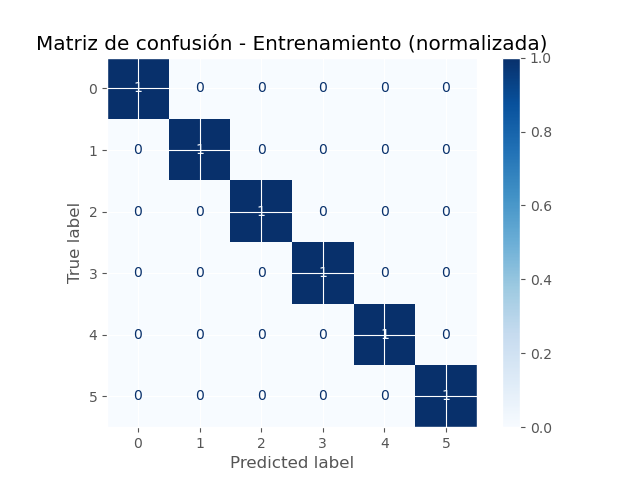

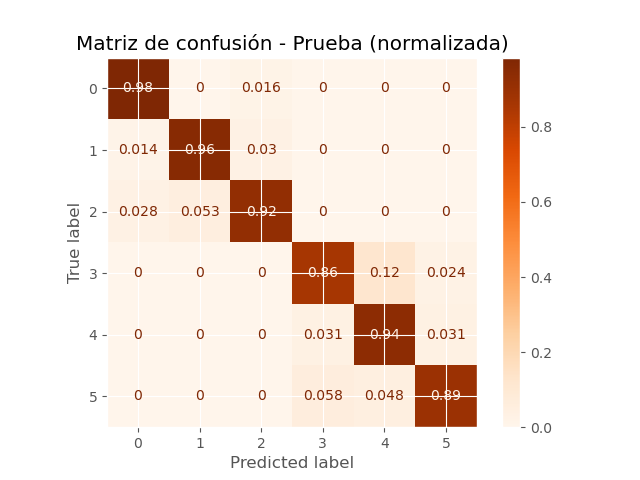

In [82]:
plt.close()
clasificador = RF(n_estimators=200,       
    max_depth=None,            
    min_samples_split=4,     
    min_samples_leaf=1,     
    max_features='sqrt',    
    random_state=42
)
clasificador.fit(X_train,y_train)

y_pred_train_RF = clasificador.predict(X_train)
y_pred_test_RF = clasificador.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test_RF))
# Matriz de confusión para el conjunto de entrenamiento
cm_train_norm = confusion_matrix(y_train, y_pred_train_RF, normalize='true')
ConfusionMatrixDisplay(cm_train_norm).plot(cmap='Blues')
plt.title("Matriz de confusión - Entrenamiento (normalizada)")

# Matriz de confusión para el conjunto de test
cm_test_norm = confusion_matrix(y_test, y_pred_test_RF , normalize='true')
ConfusionMatrixDisplay(cm_test_norm).plot(cmap='Oranges')
plt.title("Matriz de confusión - Prueba (normalizada)")
